## Product and Ratio Distributions
Given $X$ and $Y$ are statistically independent random variables (RVs), the statistical distributions of the RV $Z$ given by $Z=XY$ and $Z=X/Y$ are called product and ratio distributions, respectively. The estimation of the probability distribution functions (PDFs) $Z$ from the known distributions $X$ and $Y$ is discussed below.

### Product Distribution
Let $f_X$ and $f_Y$ be the PDFs of the RVs $X$ and $Y$, respectively. Let $F_X$ and $F_Y$ be corresponding cumulative distribution functions (CDFs). Then the CDF for the $Z=XY$ can be written as:
$$
\begin{align}
    F_Z(z)  &= P\{Z \leq z\}\\
            &= P\{XY \leq z\}\\
            &= P\{X \leq z/Y, Y \geq 0\} + P\{X \geq z/Y, Y \leq 0\}\\
            &= \int_{0}^{\infty} f_Y(y) \int_{-\infty}^{z/y} f_X(x)\ dxdy\ +\ \int_{-\infty}^0 f_Y(y) \int_{z/y}^{\infty} f_X(x)\ dxdy \tag{1}
\end{align}
$$

The PDF can be estimated from the CDF $F_Z$ as below:
$$
\begin{align}
    f_Z(z)  &= \dfrac{d}{dz} F_Z(z)\\
            &= \int_{-\infty}^{\infty} f_Y(y)f_X(z/y) \frac{1}{|y|} dy \tag{2}
\end{align}
$$
### Ratio Distribution
The objective here is to derive the statistical distribution $f_Z$ of the RV $Z=X/Y$ from the PDFs $f_X$ and $f_Y$. A simple derivation is achieved by changing $Y$ to $1/Y$ in the product distribution. This yields
$$
f_Z(z) = \int_{-\infty}^{\infty} |y|\ f_Y(y)f_X(z/y) dy \tag{3}
$$

Estimation of probability distributions of the above cases are implemented as Python functions 'map_rv2cos' and 'map_rv2tan' below. They are further validated for various distributions of $X$ and $Y$. As these distributions generated for validation are discrete distributions, appropriate modifications are made to the Eq.s (1)-(3).

In [1]:
## SETUP
%config Completer.use_jedi = False  # To avoid delays in autocompletion during coding.
import os
import sys
os.chdir('..')  # changing to a higher dir to access custom modules
cwd = os.getcwd()
sys.path.append(cwd)

import numpy as np  # numpy for matrix, linear-algebra, and other numerical studies.
from matplotlib_settings import *
from itertools import product
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

In [2]:
def product_distr(x, y, z, pmfx, pmfy):
    assert len(x) == len(pmfx)
    assert len(y) == len(pmfy)
    
#     zmat = np.outer(x, y)
    dz = np.mean(np.diff(z))  # TODO: change this later
    fx = interp1d(x, pmfx, kind='quadratic', fill_value='extrapolate')
    pmfz= []
    dy = np.gradient(y)
    for k in z:
        p = np.sum(np.abs(y) * pmfy * fx(k / y) * dy)
        pmfz.append(p)
    return pmfz

In [3]:
# Functions to estimate orientation and anisotropy tensors from a given probability distribution (histogram), 
# and further convert them to PMF.

def orient_tensor_2D(prob_phi, phi_vals):
    """
    Function to estimate orientation and anisotropy tensors from a given probability distribution (histogram).
    """
    if len(phi_vals) == len(prob_phi) + 1:
        phi_vals = 0.5 * (phi_vals[:-1] + phi_vals[1:])
    elif len(phi_vals) == len(prob_phi):
        pass
    else:
        raise ValueError("check dimensions of prob_phi and phi_vals: {0}, {1}".format(len(prob_phi), len(phi_valsDeg)))

    # check for total probability = 1
    d_phi = np.mean(phi_vals[1:] - phi_vals[:-1])  # mean bin width of phi values (delta_phi)
    total_prob = np.sum(prob_phi) * d_phi
    if not np.isclose(total_prob, 1.):
        print("Total probability not 1: {:1.2f}".format(total_prob))

    # setup
    order = 2
    coords = (0, 1)  # possible coordinates in 2D space
    base = tuple([coords] * order)  # tensor space dimension = coords * order
    indices = list(product(*base))  # all possible tensor indices Qijkl

    # direction cosines
    u = np.zeros((2, len(phi_vals)))
    u[0, :] = np.cos(phi_vals)
    u[1, :] = np.sin(phi_vals)

    # Orientation Tensor
    Q = []
    for indx in indices:
        # print("index: ", indx)
        elem = prob_phi
        for i in indx:
            elem = elem * u[i, :]
        Q.append(np.sum(elem))
    Q = np.array(Q).reshape((order, order)) * d_phi
    A = Q - 0.5*np.eye(order)
    
    return Q, A


def tensor2odf_2D(phivals, A):
    """
    Function to estimate PMF from tensor.
    """
    assert A.shape == (2, 2), 'Only two-dimensional tensors accepted'
    c = np.cos(phivals)
    s = np.sin(phivals)
    a = A.ravel()
    afunc = a[0] * (c*c - 0.5) + a[1] * (c*s) + a[2] * (s*c) + a[3] * (s*s - 0.5)
    odf = 1 / (2*np.pi) + (2 / np.pi) * afunc
    return odf

In [4]:
# Generating distributions to validate the python implementations.
N = 1000  # total number of observations in the discrete distribution 
thetaLow, thetaHigh = (0, np.pi)  # domain of theta, the primary RV
thetaVals = np.deg2rad(np.arange(0, 180))  # in radians
thetaBins = np.deg2rad(np.arange(0, 181, 10)) # bin edges for plotting histogram of the distribution
thetaBinc = 0.5 * (thetaBins[1:] + thetaBins[:-1])

mu = np.pi/2
kappa = [0.1, 0.25, 0.5, 1., 5.]
thetaDistrs = [np.random.uniform(low=thetaLow, high=thetaHigh, size=N)]  # uniform distribution

for k in kappa:
    thetaDistrs.append(np.random.vonmises(mu, k, N))  # von Mises distributions centred around 90 deg


In [5]:
xVals = np.tan(thetaBinc-np.pi/2)
xDistrs = [np.tan(distr-np.pi/2) for distr in thetaDistrs]
yVals = np.cos(thetaBinc)
yDistrs = [np.cos(distr) for distr in thetaDistrs]

In [6]:
# Defining the PMF of above distributions
xPMFs = []
for distr in xDistrs:
    h, b = np.histogram(distr, bins=xVals, density=True)
    Q, A = orient_tensor_2D(h, xVals)
    pmf = tensor2odf_2D(xVals, A) * 2
    xPMFs.append(pmf)

yPMFs = []
for distr in yDistrs:
    h, b = np.histogram(distr, bins=yVals[::-1], density=True)
    Q, A = orient_tensor_2D(h, yVals)
    pmf = tensor2odf_2D(yVals, A) * 2
    yPMFs.append(pmf)

Total probability not 1: 2.93
Total probability not 1: 2.82
Total probability not 1: 2.88
Total probability not 1: 2.95
Total probability not 1: 3.17
Total probability not 1: 4.45
Total probability not 1: -1.43
Total probability not 1: -1.42
Total probability not 1: -1.43
Total probability not 1: -1.39
Total probability not 1: -1.27
Total probability not 1: -0.84


In [9]:
zDistrs = [xdistr * ydistr for xdistr, ydistr in zip(xDistrs, yDistrs)]
zVals = xVals
zPMFs = [product_distr(xVals, yVals[::-1], zVals, pmfx, pmfy[::-1]) for pmfx, pmfy in zip(xPMFs, yPMFs)]

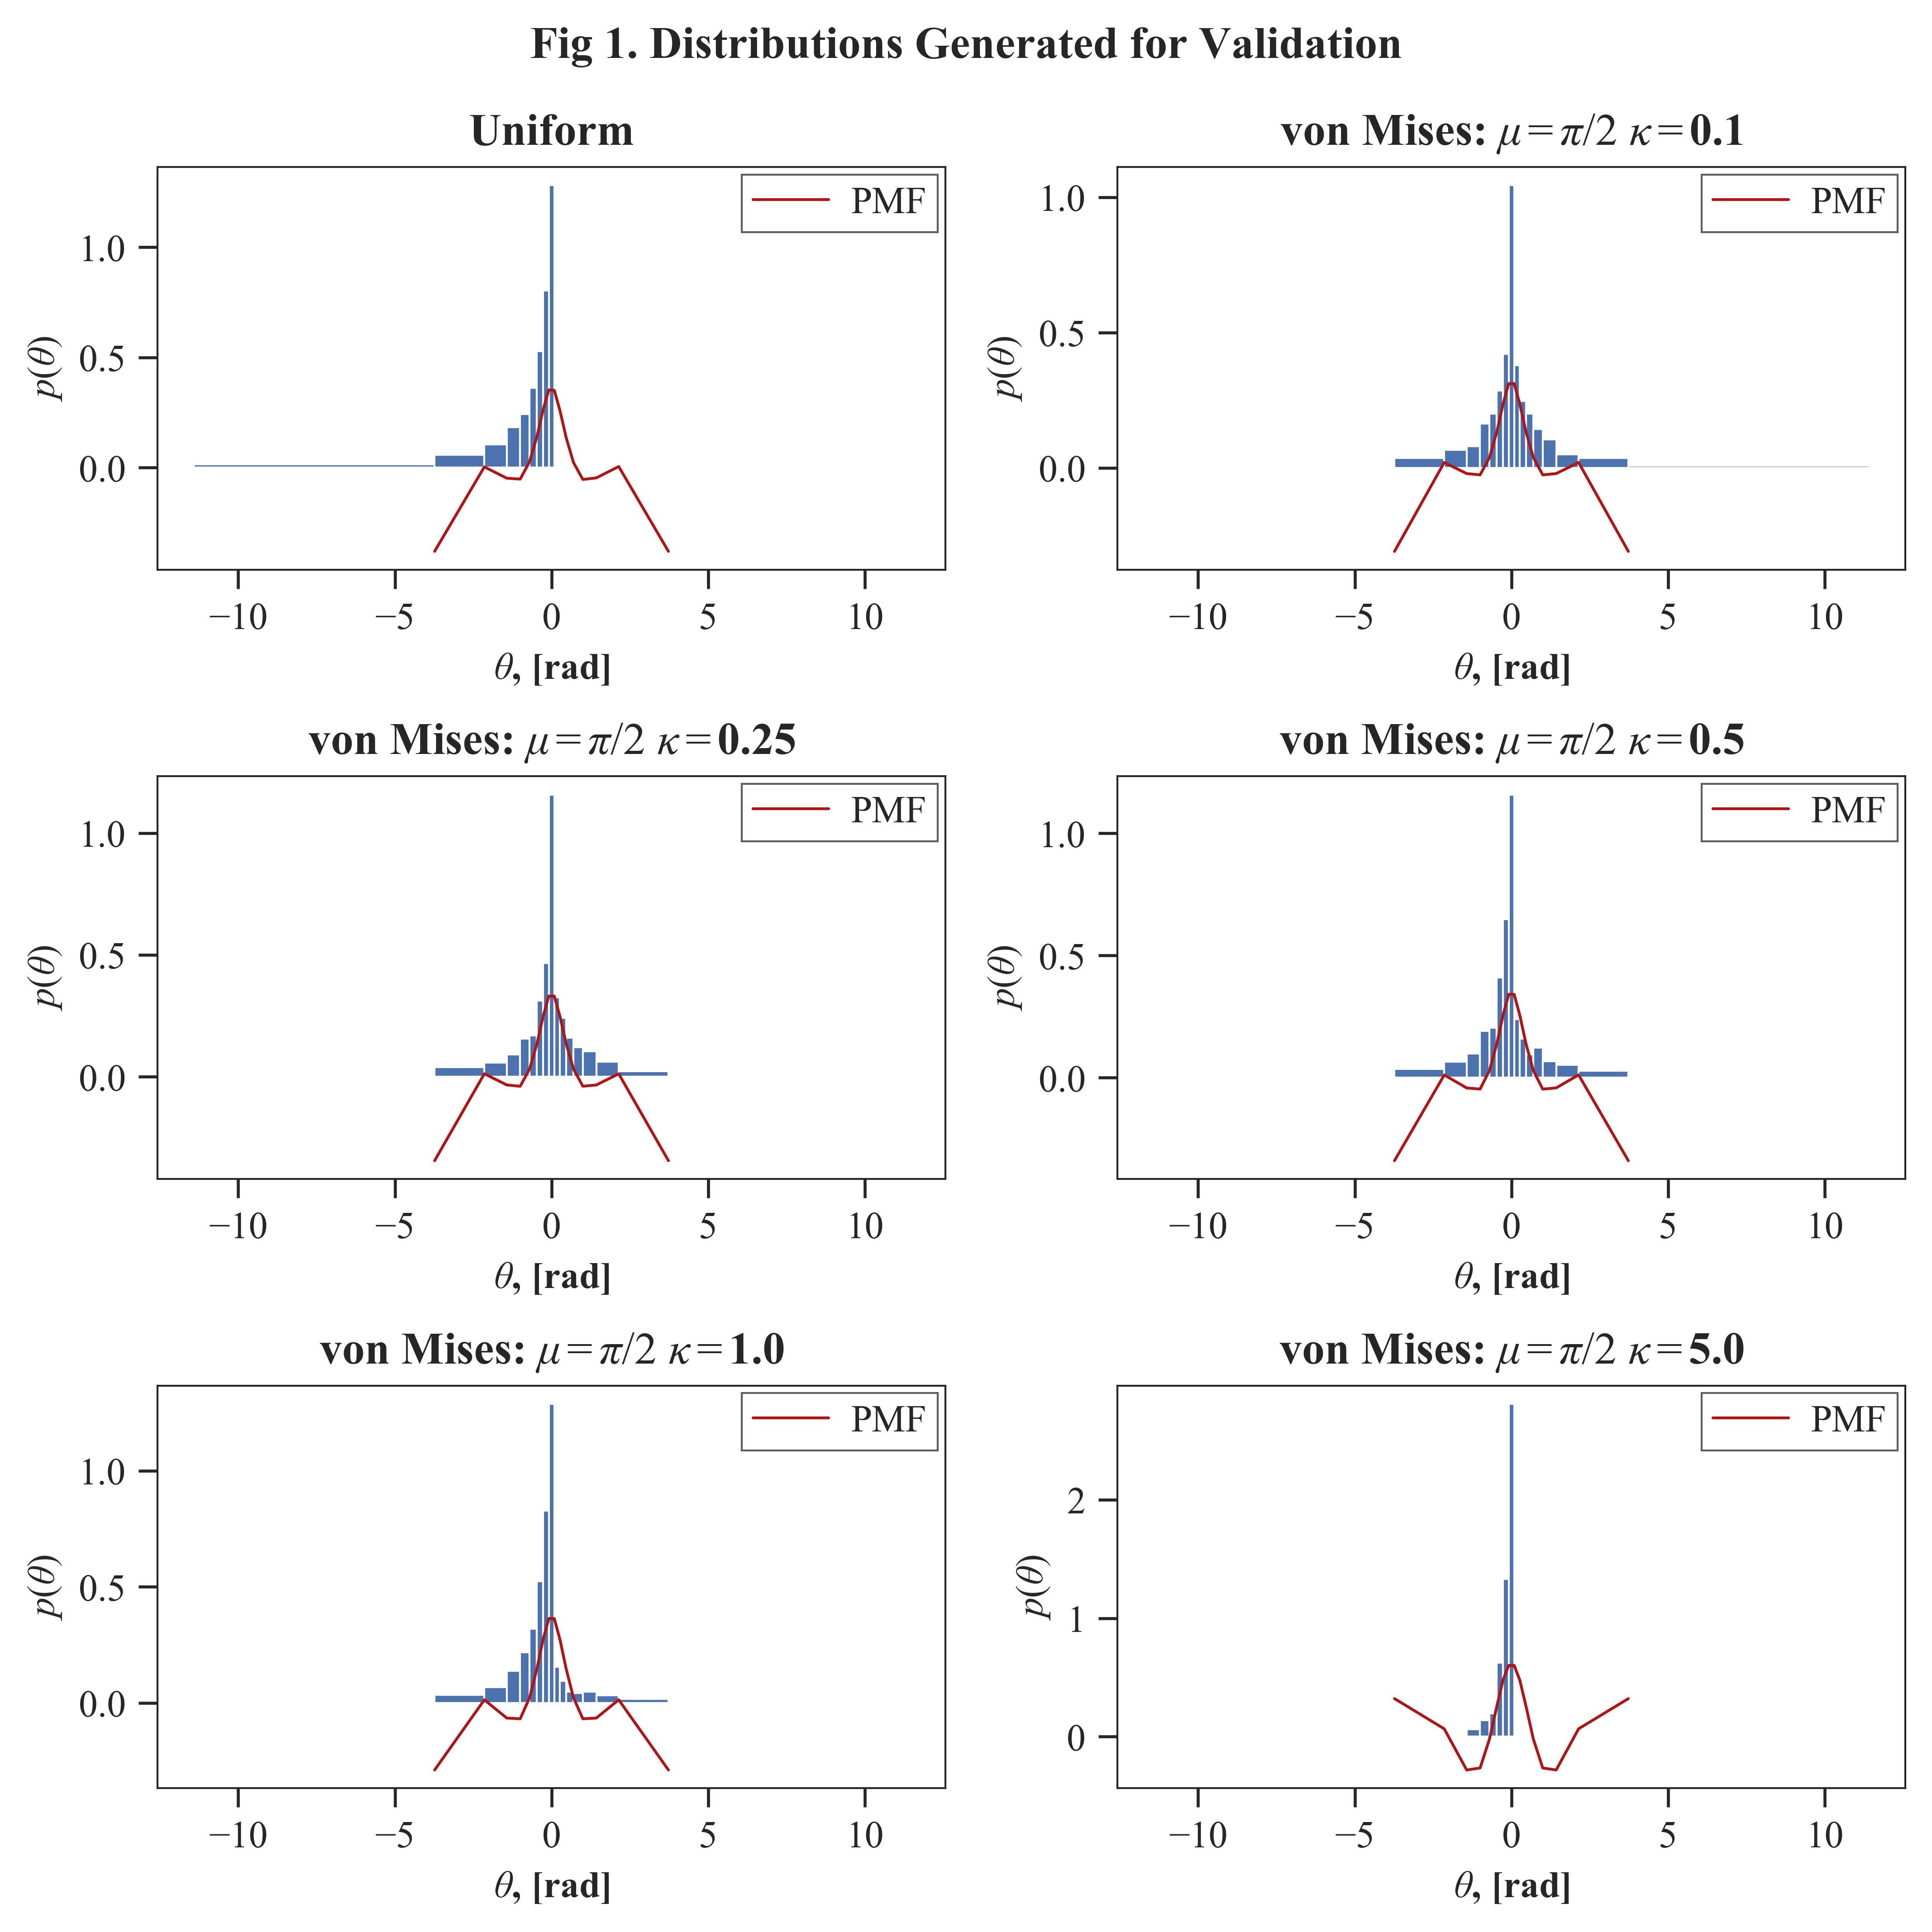

In [10]:
# Figure: Visualise the distributions generated for validation.
fig, axes = plt.subplots(3, 2, figsize=(7, 7))
axs = axes.ravel()

for n, (distr, pmf) in enumerate(zip(zDistrs, zPMFs)):
    ax = axs[n]
    h, b, _ = ax.hist(distr, bins=zVals, density=True)
    ax.plot(zVals[1:-1], pmf[1:-1], lw=0.75, color=np.asarray([176, 21, 21]) / 255, label='PMF')
    if n == 0:
        ax.set_title("Uniform")
    else:
        ax.set_title("von Mises: $\mu=\pi/2$ $\kappa=${0}".format(kappa[n-1]))
    ax.set_xlabel("$\\theta$, [rad]")
    ax.set_ylabel("$p(\\theta)$")
    ax.legend(loc='upper right')

fig.suptitle("Fig 1. Distributions Generated for Validation")
plt.show()